In [37]:
import random
import math
import matplotlib.pyplot as plt
from deap import base,  benchmarks, creator, tools
import array
import numpy



In [38]:
class Individual_ES:
    def __init__(self,l_bound, h_bound, dimension):
        self.position = [random.uniform(l_bound, h_bound) for _ in range(dimension)]

        vmax = 0.1 * (h_bound - l_bound)
        self.velocity = [random.uniform(-vmax, vmax) for _ in range(dimension)]

        self.p_best = self.position.copy()
        self.g_best = None

        self.fitness = float('inf')
        self.b_fitness = float('inf')
        

In [ ]:


def generateES(icls, scls, size, imin, imax, smin, smax):
    ind = icls(random.uniform(imin, imax) for _ in range(size))
    ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))
    return ind

def checkStrategy(minstrategy):
    def decorator(func):
        def wrappper(*args, **kargs):
            children = func(*args, **kargs)
            for child in children:
                for i, s in enumerate(child.strategy):
                    if s < minstrategy:
                        child.strategy[i] = minstrategy
            return children
        return wrappper
    return decorator


def ES_algo( toolbox,mu, lamda_, cxpb=0.6, mutpb=0.3, max_iter=100):
    
    # Init mu number of parents 
    pop = toolbox.population(n=mu)

    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"


    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)

    for gen in range(1, max_iter +1):
        
        offsprings = []

        while len(offsprings) < lamda_:
            # Probability of selecting parents
            # Creats offspring
            if random.random() < cxpb:
                p1, p2 = random.sample(pop,2)
                children = toolbox.mate(p1,p2)
            else:
                parent = random.choice(pop)
                children = [parent]

            for child in children:
                if random.random() < mutpb:
                    toolbox.mutate(child)

                child.fitness.values = toolbox.evaluate(child)

            offsprings.extend(children)


            # Select best  mu indivudals
        pop = tools.selBest(offsprings, mu)

        hof.update(pop)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(pop), **record)
        print(f"Gen {gen}: {record}")
        

    return pop, hof, logbook


# Will do adaptive eso
def ES(dimension, fitness, mu, lambda_, l_bound, h_bound, min_mut, max_mut, max_iter=100):

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", array.array, typecode="d", fitness=creator.FitnessMin, strategy=None)
    creator.create("Strategy", array.array, typecode="d")

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, l_bound, h_bound)
    toolbox.register("individual", generateES, creator.Individual, creator.Strategy,
    dimension, l_bound, h_bound, min_mut, max_mut)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxESBlend, alpha=0.1)

    # This samples from a normal distribution
    toolbox.register("mutate", tools.mutESLogNormal, c=0.1, indpb=0.05)
    toolbox.register("select", tools.selRandom, k=3)
    toolbox.register("evaluate", fitness)

    toolbox.decorate("mate", checkStrategy(min_mut))
    toolbox.decorate("mutate", checkStrategy(min_mut))

    (pop, hof, logbook) = ES_algo(toolbox, mu, lambda_, max_iter=max_iter)


    return logbook, hof


In [40]:
def rosenbrock_fitness(x):
    D = len(x)

    total = 0.0
    
    for i in range(D-1):
        total += 100 * (x[i+1] - x[i]**2)**2 + (x[i] - 1)**2
    return (total,)

def griewank_fitness(x):

    sum_term = sum(xi**2 / 4000 for xi in x)

    prod_term = 1.0

    for i, xi in enumerate(x, start=1):
        prod_term *= math.cos(xi / math.sqrt(i))
    return (sum_term - prod_term + 1,)

In [41]:
def plot_fitness(fitnesses, title="Fitness Over Epochs"):
    plt.figure(figsize=(10, 6))
    plt.plot(fitnesses, label="Fitness")
    plt.xlabel("Epoch")
    plt.ylabel("Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

Gen 1: {'avg': np.float64(138083723.99999037), 'std': np.float64(36161941.60067707), 'min': np.float64(64508593.32975233), 'max': np.float64(205730180.38017315)}
Gen 2: {'avg': np.float64(30063367.572281353), 'std': np.float64(10368055.203985363), 'min': np.float64(9892423.856961785), 'max': np.float64(44326034.64680465)}
Gen 3: {'avg': np.float64(2180237.1038934435), 'std': np.float64(701168.1621533873), 'min': np.float64(1401136.2312811879), 'max': np.float64(3525912.0080655073)}
Gen 4: {'avg': np.float64(928275.0710991014), 'std': np.float64(5969.869653661579), 'min': np.float64(925605.2642266216), 'max': np.float64(941624.1054615021)}
Gen 5: {'avg': np.float64(952861.9095103267), 'std': np.float64(13994.412252401931), 'min': np.float64(927494.8830820958), 'max': np.float64(960582.3088580496)}
Gen 6: {'avg': np.float64(946226.3048127146), 'std': np.float64(0.0), 'min': np.float64(946226.3048127146), 'max': np.float64(946226.3048127146)}
Gen 7: {'avg': np.float64(938182.7710101965), 

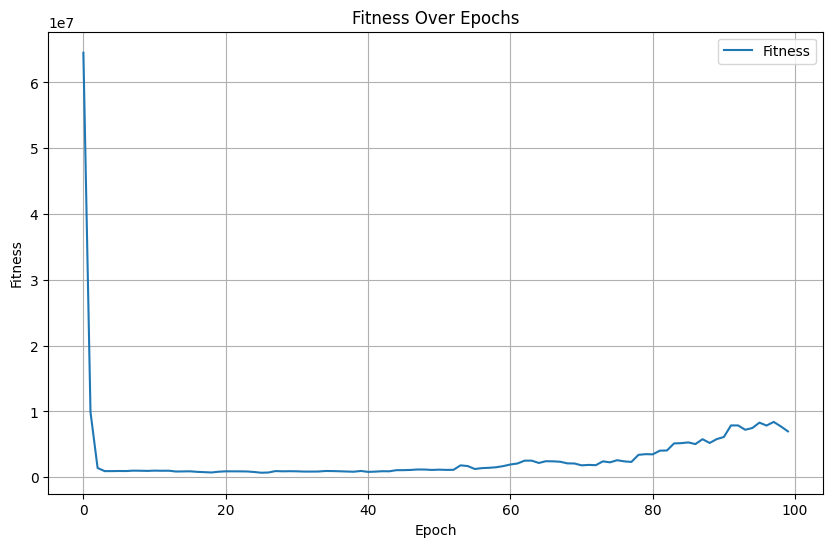

In [42]:
(logbook,hfa) = ES(30,rosenbrock_fitness, 30, 50, -30, 30, 0.1, 1)

best_fitness_per_gen = logbook.select("min")

plot_fitness(best_fitness_per_gen)